# 1. Setup and Installation


In [3]:
# Install required libraries
!pip install pyswarms
!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.4 MB/s eta 0:00:00


# 2. Imports and Configuration

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Evolutionary Algorithms libraries
import pyswarms as ps
from deap import base, creator, tools, algorithms
import random

# Reproducibility
np.random.seed(42)
random.seed(42)


# Task A: Data Preprocessing

In [1]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')
print("Drive mounted at /content/drive")

Mounted at /content/drive
Drive mounted at /content/drive


In [5]:
# Load the dataset
# Assuming the file is in the current working directory
train_path = "/content/drive/MyDrive/Fundamental of Intelligent Systems/Final/loan_train.csv"
df = pd.read_csv(train_path)

print(f"Original Data Shape: {df.shape}")

# Drop missing values
df_clean = df.dropna().copy()
print(f"Shape after removing NaNs: {df_clean.shape}")

# Display first few rows to verify
df_clean.head()


Original Data Shape: (614, 12)
Shape after removing NaNs: (499, 12)


,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


2. Label Encoding

In [ ]:
le = LabelEncoder()

# Columns to encode based on the problem statement
cols_to_encode = [
    'Gender', 'Married', 'Dependents', 'Education',
    'Self_Employed', 'Area', 'Status'
]

print("\nEncoding Categorical Variables:")
for col in cols_to_encode:
    if col in df_clean.columns:
        df_clean[col] = le.fit_transform(df_clean[col])
        print(f" - {col} encoded successfully.")
    else:
        print(f" ! Warning: Column '{col}' not found in dataset.")

# Display processed data sample
print("\nFirst 5 rows of processed data:")
display(df_clean.head())



Encoding Categorical Variables:
 - Gender encoded successfully.
 - Married encoded successfully.
 - Dependents encoded successfully.
 - Education encoded successfully.
 - Self_Employed encoded successfully.
 - Area encoded successfully.
 - Status encoded successfully.

First 5 rows of processed data:


,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900,0.0,15000000,360.0,1.0,2,1
1,1,1,1,0,0,458300,150800.0,12800000,360.0,1.0,0,0
2,1,1,0,0,1,300000,0.0,6600000,360.0,1.0,2,1
3,1,1,0,1,0,258300,235800.0,12000000,360.0,1.0,2,1
4,1,0,0,0,0,600000,0.0,14100000,360.0,1.0,2,1


3. Train/Test Split

In [ ]:
# Separate Features (X) and Target (y)
X = df_clean.drop('Status', axis=1)
y = df_clean['Status']

# Convert to numpy arrays (preferred for Pyswarms/DEAP)
X_arr = X.values
y_arr = y.values

# Split data: 70% Train, 30% Test
X_train, X_test, y_train, y_test = train_test_split(
    X_arr, y_arr, test_size=0.30, random_state=42
)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape:  {X_test.shape}")


Training Shape: (349, 11)
Testing Shape:  (150, 11)


# Task B: Feature Selection using Particle Swarm Optimization (PSO)


In [ ]:
def f_per_particle(m, alpha=0.9):
    """
    Computes the cost for a single particle (binary mask).
    """
    # Get indices of selected features (where mask is 1)
    if np.count_nonzero(m) == 0:
        return 1.0  # High penalty if no feature is selected

    # Select columns
    X_subset_train = X_train[:, m == 1]
    X_subset_test  = X_test[:, m == 1]

    # Train Classifier
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_subset_train, y_train)

    # Predict and Calculate Accuracy
    y_pred = clf.predict(X_subset_test)
    acc = accuracy_score(y_test, y_pred)

    # Calculate Feature Ratio
    feature_ratio = (X_subset_train.shape[1] / X_arr.shape[1])

    # Calculate Cost J
    j = (alpha * (1.0 - acc)) + ((1.0 - alpha) * feature_ratio)

    return j

def f(x, alpha=0.9):
    """Wrapper for the whole swarm."""
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)


2. Run PSO

In [ ]:
# PSO Hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 50, 'p': 2}
dimensions = X_arr.shape[1] # 11 features

# Initialize Binary PSO
optimizer = ps.discrete.binary.BinaryPSO(
    n_particles=50, dimensions=dimensions, options=options
)

print("Starting PSO Optimization...")
# Run optimization
cost, pos = optimizer.optimize(f, iters=100)


2026-02-11 12:03:56,745 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 50, 'p': 2}


Starting PSO Optimization...


pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.171
2026-02-11 12:09:55,043 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.17109090909090915, best pos: [0 0 0 0 0 0 0 0 0 1 0]


3. PSO Results


In [ ]:
# Extract selected features
selected_indices_pso = np.where(pos == 1)[0]
selected_features_pso = X.columns[selected_indices_pso]

# Calculate Final Accuracy
clf_pso = RandomForestClassifier(n_estimators=50, random_state=42)
clf_pso.fit(X_train[:, selected_indices_pso], y_train)
acc_pso = accuracy_score(y_test, clf_pso.predict(X_test[:, selected_indices_pso]))

print("\n--- PSO Results ---")
print(f"Minimum Cost: {cost:.4f}")
print(f"Selected Features ({len(selected_features_pso)}): {list(selected_features_pso)}")
print(f"Model Accuracy: {acc_pso:.4f}")



--- PSO Results ---
Minimum Cost: 0.1711
Selected Features (1): ['Credit_History']
Model Accuracy: 0.8200


# Task C: Feature Selection using Genetic Algorithm (GA)


1. Setup DEAP Framework

In [ ]:
# Clear previous creator definitions if re-running
if hasattr(creator, "FitnessMin"): del creator.FitnessMin
if hasattr(creator, "Individual"): del creator.Individual

# Define specific Fitness class (Minimization)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator: 0 or 1
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
n_features = X_arr.shape[1]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


2. Define GA Operators and Evaluation


In [ ]:
def evalFeatureSelection(individual):
    """GA Evaluation function. Same logic as PSO fitness."""
    # Convert individual list to numpy array for boolean indexing
    mask = np.array(individual)

    # Calculate cost using the helper defined in PSO section
    # Note: f_per_particle expects a numpy array
    return f_per_particle(mask), # Return as tuple

# Register Operators
toolbox.register("evaluate", evalFeatureSelection)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


3. Run GA

In [ ]:
POP_SIZE = 50
N_GEN = 50
CX_PB = 0.9
MUT_PB = 0.1

print("Starting GA Optimization...")
pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1) # Store best individual

# Statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Run GA
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=CX_PB, mutpb=MUT_PB,
    ngen=N_GEN, stats=stats, halloffame=hof, verbose=True
)


Starting GA Optimization...
gen	nevals	avg     	min     	max     
0  	50    	0.335935	0.189273	0.483455
1  	44    	0.288364	0.189273	0.447273
2  	43    	0.244749	0.180182	0.360364
3  	46    	0.224029	0.171091	0.285455
4  	44    	0.204004	0.171091	0.282364
5  	46    	0.184175	0.171091	0.231455
6  	47    	0.17776 	0.171091	0.210364
7  	49    	0.173091	0.171091	0.192182
8  	49    	0.171273	0.171091	0.180182
9  	48    	0.171818	0.171091	0.180182
10 	44    	0.204247	0.171091	1       
11 	48    	0.173196	0.171091	0.267273
12 	50    	0.171513	0.171091	0.192182
13 	46    	0.171455	0.171091	0.189273
14 	48    	0.173436	0.171091	0.246182
15 	50    	0.171455	0.171091	0.180182
16 	47    	0.175542	0.171091	0.279273
17 	46    	0.171091	0.171091	0.171091
18 	45    	0.171091	0.171091	0.171091
19 	48    	0.171636	0.171091	0.180182
20 	43    	0.171818	0.171091	0.189273
21 	44    	0.171636	0.171091	0.180182
22 	48    	0.171091	0.171091	0.171091
23 	47    	0.187669	0.171091	1       
24 	44    	0.172778	0.

4. GA Results


In [ ]:
best_ind = hof[0]
best_cost_ga = best_ind.fitness.values[0]
selected_indices_ga = [i for i, x in enumerate(best_ind) if x == 1]
selected_features_ga = X.columns[selected_indices_ga]

# Calculate Final Accuracy
clf_ga = RandomForestClassifier(n_estimators=50, random_state=42)
clf_ga.fit(X_train[:, selected_indices_ga], y_train)
acc_ga = accuracy_score(y_test, clf_ga.predict(X_test[:, selected_indices_ga]))

print("\n--- GA Results ---")
print(f"Minimum Cost: {best_cost_ga:.4f}")
print(f"Selected Features ({len(selected_features_ga)}): {list(selected_features_ga)}")
print(f"Model Accuracy: {acc_ga:.4f}")



--- GA Results ---
Minimum Cost: 0.1711
Selected Features (1): ['Credit_History']
Model Accuracy: 0.8200


# Task D & E: Comparative Analysis and Feature Importance


In [ ]:
# Create Comparison Table
results_data = {
    'Algorithm': ['PSO', 'GA'],
    'Selected Features Count': [len(selected_features_pso), len(selected_features_ga)],
    'Model Accuracy': [acc_pso, acc_ga],
    'Cost': [cost, best_cost_ga]
}

comp_df = pd.DataFrame(results_data)
print("--- Performance Comparison ---")
display(comp_df)

# Feature Importance Analysis
print("\n--- Selected Features Analysis ---")
print(f"PSO Features: {list(selected_features_pso)}")
print(f"GA Features:  {list(selected_features_ga)}")

if set(selected_features_pso) == set(selected_features_ga):
    print("\nObservation: Both algorithms converged to the EXACT SAME subset.")
    print(f"Key Feature Identified: {list(selected_features_pso)[0]}")
    print("Interpretation: 'Credit_History' is strictly dominant. Adding other features adds noise/penalty without sufficient accuracy gain.")
else:
    print("\nObservation: Algorithms found different subsets.")


--- Performance Comparison ---


,Algorithm,Selected Features Count,Model Accuracy,Cost
0,PSO,1,0.82,0.171091
1,GA,1,0.82,0.171091



--- Selected Features Analysis ---
PSO Features: ['Credit_History']
GA Features:  ['Credit_History']

Observation: Both algorithms converged to the EXACT SAME subset.
Key Feature Identified: Credit_History
Interpretation: 'Credit_History' is strictly dominant. Adding other features adds noise/penalty without sufficient accuracy gain.


Visual Comparison (Bar Chart)

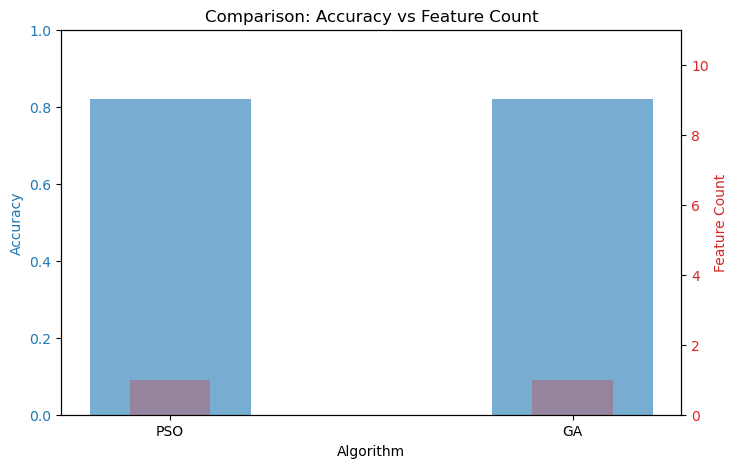

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(comp_df['Algorithm'], comp_df['Model Accuracy'], color=color, alpha=0.6, width=0.4, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.0)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Feature Count', color=color)
ax2.bar(comp_df['Algorithm'], comp_df['Selected Features Count'], color=color, alpha=0.3, width=0.2, label='Count')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 11)

plt.title('Comparison: Accuracy vs Feature Count')
plt.show()


# Task F: Convergence Analysis


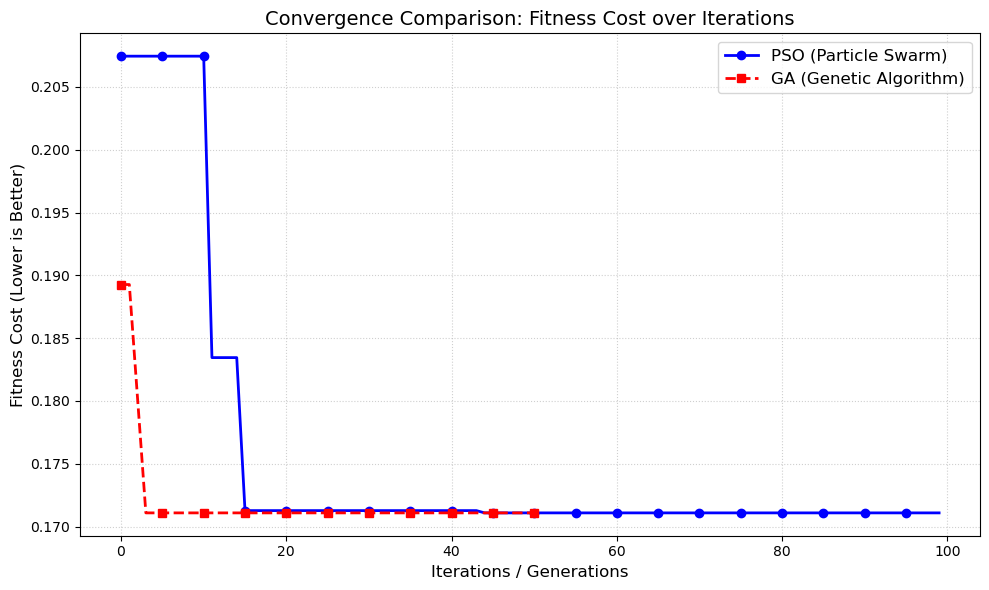

--- Convergence Analysis ---
PSO Final Cost: 0.1711
GA Final Cost:  0.1711


In [ ]:
# Extract history
# PSO: optimizer.cost_history
pso_history = optimizer.cost_history

# GA: Extract 'min' from logbook
ga_history = log.select("min")

# Plot
plt.figure(figsize=(10, 6))

# PSO Plot
plt.plot(pso_history, label='PSO (Particle Swarm)', color='blue', linewidth=2, marker='o', markevery=5)

# GA Plot
plt.plot(ga_history, label='GA (Genetic Algorithm)', color='red', linewidth=2, linestyle='--', marker='s', markevery=5)

plt.title('Convergence Comparison: Fitness Cost over Iterations', fontsize=14)
plt.xlabel('Iterations / Generations', fontsize=12)
plt.ylabel('Fitness Cost (Lower is Better)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Convergence Speed Analysis
print("--- Convergence Analysis ---")
print(f"PSO Final Cost: {pso_history[-1]:.4f}")
print(f"GA Final Cost:  {ga_history[-1]:.4f}")
